In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

In [22]:
def generate_adj(alphas,thetas):
    num_nodes = len(alphas)
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            norm_diff = np.linalg.norm(thetas[i] - thetas[j])**2
            m_ij = alphas[i] + alphas[j] - norm_diff
            adjacency_matrix[i][j] = np.random.poisson(lam = np.exp(m_ij))
            adjacency_matrix[j][i] = adjacency_matrix[i][j]
    return adjacency_matrix

def distance_matrix(point_theta):
    n = point_theta.shape[0]
    distances = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(point_theta[i] - point_theta[j])**2
            distances[i, j] = dist
            distances[j, i] = dist
    return distances

def generate_M_matrix(alphas, thetas):
    num_nodes = len(alphas)
    M = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            norm_squared = np.linalg.norm(thetas[i] - thetas[j]) ** 2
            M[i][j] = alphas[i] + alphas[j] - norm_squared
            M[j][i] = M[i][j]
    return M

def f(A, alphas, thetas):
    M = generate_M_matrix(alphas, thetas)
    num_nodes = A.shape[0]
    result = 0
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                result += -np.exp(M[i][j])-np.log(factorial(A[i][j]))+A[i][j]*M[i][j]
    return result

def Projection(X,C):
    return X if np.linalg.norm(X) < C else C*X/np.linalg.norm(X)

def gradient_theta(A, alphas, thetas):
    num_nodes = len(alphas)
    gradient = np.zeros_like(thetas)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                norm_squared = np.linalg.norm(thetas[i] - thetas[j]) ** 2
                term = alphas[i] + alphas[j] - norm_squared
                # sigmoid_term = sigmoid(alphas[i] + alphas[j] - norm_squared)

                gradient[i] += -2 * A[i][j] * (thetas[i] - thetas[j]) + \
                                2 * (thetas[i] - thetas[j]) * np.exp(term)*term
    return gradient

def gradient_alpha(A, alphas, thetas):
    num_nodes = len(alphas)
    gradient = np.zeros_like(alphas)
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                norm_squared = np.linalg.norm(thetas[i] - thetas[j]) ** 2
                term = alphas[i] + alphas[j] - norm_squared
                # sigmoid_term = sigmoid(alphas[i] + alphas[j] - norm_squared)
                gradient[i] += A[i][j] - term*np.exp(term)
    
    return gradient

In [23]:
def main(num_samples, k, C, initial_learning_rate, tolerance):
    # Generate true parameters
    true_alpha = np.random.rand(num_samples)
    true_theta = np.random.uniform(-45*np.pi/161, 45*np.pi/161, num_samples*k).reshape(num_samples, -1)

    # Generate adjacency matrix
    adjacency_matrix = generate_adj(true_alpha, true_theta)

    # Generate distance matrix
    distance_matrix_ = distance_matrix(true_theta)

    # Initialize predicted parameters
    pred_alpha = np.random.rand(num_samples)
    pred_theta = np.random.uniform(-45*np.pi/161, 45*np.pi/161, num_samples*k).reshape(num_samples, -1)

    # Initial log likelihood
    logli = f(adjacency_matrix, pred_alpha, pred_theta)
    prev_logli = logli  # Initialize previous log likelihood

    # Training loop
    flag = True
    iter = 0
    learning_rate = initial_learning_rate  # Initialize learning rate

    # list
    avg_loss_theta = []
    avg_loss_alpha = []
    max_loss_theta = []
    max_loss_alpha = []
    logli_list = []

    while flag:
        # Update theta
        grad_y = gradient_theta(adjacency_matrix, pred_alpha, pred_theta)
        temp_theta = Projection(pred_theta + learning_rate * grad_y, C)

        # Update alpha
        grad_x = gradient_alpha(adjacency_matrix, pred_alpha, temp_theta)
        temp_alpha = Projection(pred_alpha + learning_rate * grad_x, C)

        # Calculate new log likelihood
        temp_logli = f(adjacency_matrix, temp_alpha, temp_theta)
        
        # Check improvement in log likelihood
        if temp_logli - prev_logli < 0:
            # If log likelihood decreases, reduce learning rate without updating parameters
            learning_rate /= 5
        else:
            # If log likelihood improves, update parameters and reset learning rate
            iter += 1
            pred_theta = temp_theta
            pred_alpha = temp_alpha
            logli = temp_logli

            # plot
            diff_distance = distance_matrix_-distance_matrix(pred_theta)
            diff_alpha = true_alpha-pred_alpha
            avg_loss_theta.append(np.linalg.norm(diff_distance, ord='fro')**2/len(pred_theta)**2)
            max_loss_theta.append(np.abs(diff_distance).max())             
            avg_loss_alpha.append(np.linalg.norm(diff_alpha)**2/len(pred_alpha))
            max_loss_alpha.append(np.abs(diff_alpha).max())
            logli_list.append(logli)

            # Check for convergence
            if logli - prev_logli > 0 and (logli - prev_logli)/np.abs(prev_logli) < tolerance:
                flag = False
            # Reset learning rate for the next iteration
            prev_logli = logli
            learning_rate = initial_learning_rate

    return avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta, logli_list

In [24]:
# np.random.seed(2)
num_samples = 200
k = 2
C = 10000
learning_rate  = 0.1/num_samples
tolerance = 0.0001
avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta, logli_list = main(num_samples, k, C, learning_rate, tolerance)

In [25]:
relative_errors = []

for i in range(1, len(logli_list)):
    relative_error = (logli_list[i] - logli_list[i-1])/abs(logli_list[i-1])
    relative_errors.append(relative_error)

print(relative_errors)

[0.04385807146501967, 0.013947925018721961, 0.007161586545164275, 0.004670428076242701, 0.003378896856477081, 0.0025871037646842585, 0.002069774011879944, 0.001725046353633755, 0.0014958625872263753, 0.0013473884511591271, 0.0012577013464206165, 0.001212778915885805, 0.001203506991405194, 0.0012238305593024667, 0.0012695804332722954, 0.0013376993750701506, 0.0014257043662244736, 0.0015312919565802349, 0.0016520379663473293, 0.0017851715703461927, 0.001927422667625661, 0.0020749527908185228, 0.002223383788914743, 0.002367934344150854, 0.002503661835891328, 0.0026257878868908477, 0.0027300647036450844, 0.0028131229665611206, 0.002872737663615005, 0.002907960058001495, 0.002919090579323905, 0.00290750166220037, 0.002875351065461461, 0.002825245721257754, 0.0027599191367176654, 0.0026819731448034746, 0.0025937130948309717, 0.0024970816180129754, 0.0023936760192131497, 0.002284821763490013, 0.0021716704245202177, 0.0020552937356167035, 0.0019367536413326962, 0.0018171385888878376, 0.0016975

In [26]:
len(relative_errors)

74

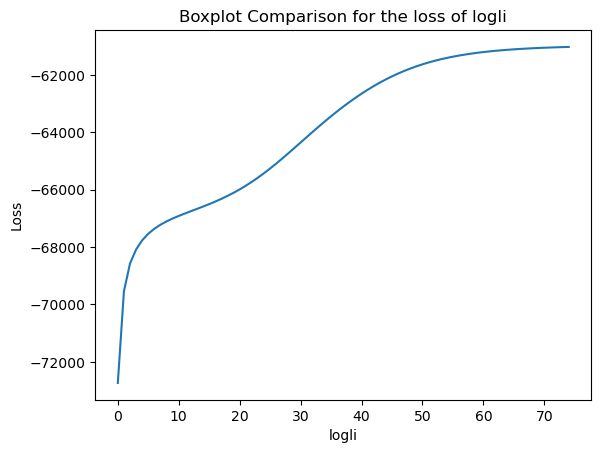

In [27]:
plt.plot(logli_list)
plt.title(fr'Boxplot Comparison for the loss of logli')
plt.xlabel('logli')
plt.ylabel('Loss')
plt.show()

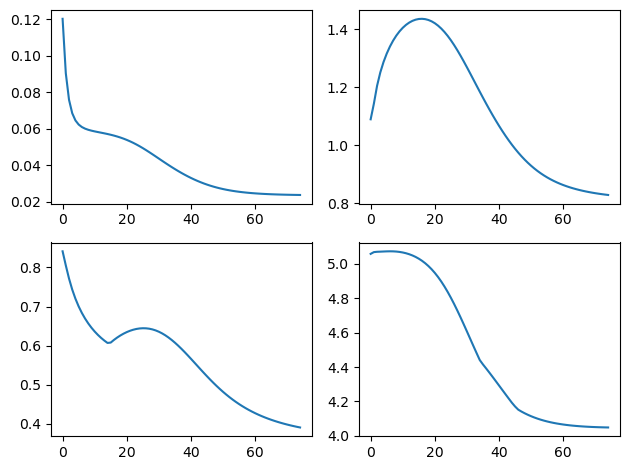

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# 定义四个列表的数据
avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta

# 创建一个 2x2 的子图布局
fig, axs = plt.subplots(2, 2)

# 绘制每个子图的线图
axs[0, 0].plot(avg_loss_alpha)
axs[0, 1].plot(avg_loss_theta)
axs[1, 0].plot(max_loss_alpha)
axs[1, 1].plot(max_loss_theta)

# 调整子图的布局和样式
plt.tight_layout()

# 显示图形
plt.show()